In [7]:
from mudpy import forward
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def build_source_time_function(rise_time,dt,total_time,stf_type='triangle',zeta=0.2,dreger_falloff_rate=4,
                               scale=True,scale_value=1.0,time_offset=0,time_offset_gauss=0,quiet=False,
                               ji_fraction=0.5):
    '''
    Compute source time function for a given rise time
    '''
    from numpy import zeros,arange,where,pi,cos,sin,isnan,exp,roll
    from scipy.integrate import trapz
    
    rise_time=float(rise_time)
    #Initialize outputs
    t=arange(0,total_time+dt,dt)
    Mdot=zeros(t.shape)
    if stf_type=='triangle':
        #Triangle gradient
        m=1/(rise_time**2)
        #Upwards intercept
        b1=0
        #Downwards intercept
        b2=m*(rise_time)
        #Assign moment rate
        i=where(t<=rise_time/2)[0]
        Mdot[i]=m*t[i]+b1
        i=where(t>rise_time/2)[0]
        Mdot[i]=-m*t[i]+b2 
        i=where(t>rise_time)[0]
        Mdot[i]=0
    elif stf_type=='cosine':   #From Liu et al. (2006) BSSA, eq 7a,7b
        tau1=0.13*rise_time
        tau2=rise_time-tau1
        Cn=pi/(1.4*pi*tau1+1.2*tau1+0.3*pi*tau2)
        #Build in pieces
        i1=where(t<tau1)[0]
        i2=where((t>=tau1) & (t<2*tau1))[0]
        i3=where((t>=2*tau1) & (t<rise_time))[0]
        Mdot[i1]=Cn*(0.7-0.7*cos(t[i1]*pi/tau1)+0.6*sin(0.5*pi*t[i1]/tau1))
        Mdot[i2]=Cn*(1.0-0.7*cos(t[i2]*pi/tau1)+0.3*cos(pi*(t[i2]-tau1)/tau2))
        Mdot[i3]=Cn*(0.3+0.3*cos(pi*(t[i3]-tau1)/tau2))
    elif stf_type=='dreger':
        tau=rise_time/dreger_falloff_rate
        Mdot=(t**zeta)*exp(-t/tau)
    elif stf_type == 'gauss_prem_i_2s':  #The decay parameter for this is fixed by instaseis/syngine
    
        decay=3.5 #Hard coded in syngine, good number for rise time to actually correspond to the function width
        center_time = 3.5858 #Hard coded in syngine
        min_rise_time = 2.1 #Rise times shorter than this are not allowed
        if rise_time < min_rise_time:
            if quiet==False:
               print('... ... ...  WARNING: rise time requested is below minimum allowed of %.1fs, defaulting to minimum' % min_rise_time)
            rise_time = min_rise_time
    
        if time_offset_gauss == 0 : #regualr gaussian with no offset (for GNSS, strong motion, etc)
            time_offset_gauss = rise_time/2
            Mdot = decay/(rise_time*pi**0.5)*exp(-((decay * (t - time_offset_gauss))/rise_time)**2)
            Mdot -= Mdot[0]
            i = where(Mdot < 0)[0]
            Mdot[i] = 0
    
        else: #regular gaussian with offset (for teleseismic, etc)
            Mdot = decay/(rise_time*pi**0.5)*exp(-((decay * (t - time_offset_gauss))/rise_time)**2)
            #Here comes the tricky bit. Need to roll the slip rate function FORWARD
            # By an ammount equal to half the new rise time minus half original rise time (2.1/2)
            t_roll = rise_time/2 - min_rise_time/2
            t_roll_samples = int(t_roll/dt)
            Mdot = roll(Mdot,t_roll_samples)
    elif stf_type == 'ji':
        
        tup = rise_time*ji_fraction
        tdown = rise_time*(1-ji_fraction)
    
        #Up going cosine
        s1 = (1./(tup+tdown))*(1-cos((pi*t)/tup))
        i = where(t>tup)[0]
        s1[i] = 0
        
        #Down going cosine
        s2 = (1./(tup+tdown))*(1+cos((pi*(t-tup))/tdown))
        i = where(t<=tup)[0]
        s2[i] = 0 
        i = where(t>tup+tdown)[0]
        s2[i] = 0
        
        #add the two 
        Mdot = s1+s2    
    
    else:
        print('ERROR: unrecognized STF type '+stf_type)
        return
    #Area of STF must be equal to dt
    if scale==True:

        area=trapz(Mdot,t)
        Mdot=Mdot*(scale_value/area)
    #Check for errors
    if isnan(Mdot[0])==True:
        print('ERROR: woops, STF has nan values!')
        return
        
    #offset origin time
    t=t+time_offset
    return t,Mdot

In [16]:
def mudpy2srf(rupt,log_file,stf_dt=0.1,stf_type='triangle',inv_or_rupt='rupt',Ndip=None,
              hypocenter=None,time_pad=5.0,minSTFpoints=16,integrate=False,Mw=None):
    '''
    Convert a mudpy .rupt or .inv file to SRF version 2 format
    
    See for SRF format description here:
        https://scec.usc.edu/scecpedia/Standard_Rupture_Format
        
    if Ndip != None it means try to apportion Nstrike and Ndip to avoid huge Nstrike number
    '''
    
    from numpy import genfromtxt,where,sin,deg2rad,array,argmin,sqrt,sign,arctan2,rad2deg,arange,ones,zeros,r_
    from pyproj import Geod
    from os import path
    from scipy.integrate import cumtrapz
    
    #Define paths to output files
    folder=path.dirname(rupt)
    basename=path.basename(rupt)
    
    if inv_or_rupt == 'rupt':
        basename=basename.replace('rupt','srf')
        srf_file=folder+'/'+basename
        basename=basename.replace('srf','src')
        src_file=folder+'/'+basename
    else:
        basename=basename.replace('inv','srf')
        srf_file=folder+'/'+basename
        basename=basename.replace('srf','src')
        src_file=folder+'/'+basename       
    
    #Read mudpy file
    f=genfromtxt(rupt)
    
    
    #Calculate stuff for the header
    
    #Get coordiantes of shallowest row
    min_row=where(f[:,3]==f[:,3].min())[0]
    fmin=f[min_row,:]
    
    #Top center longitude
    elon=fmin[:,1].mean()
    
    #Top center latitude
    elat=fmin[:,2].mean()
    
    if Ndip==None:
        #Number of faults along strike
        Nstrike=len(fmin)
        #Number of faults along dip
        Ndip=len(f)/Nstrike
    else:
        #Number of faults along strike
        Nstrike=len(f)/Ndip
        
    #Subfault dimensions (in km)
    dx_strike=f[0,10]/1000.0
    dx_dip=f[0,11]/1000.0
    
    #Segment length and width
    length=Nstrike*dx_strike
    width=Ndip*dx_dip
    
    #Segment strike and dip
    strike=f[0,4]
    dip=f[0,5]
    
    #Depth to top of fault
    depth_top=fmin[0,3]-sin(deg2rad(dip))*(dx_dip/2)
    
    if inv_or_rupt == 'rupt':
        #Location of hypocenter from log file and magnitude
        flog=open(log_file,'r')
        while True:
            line=flog.readline()
            if 'Hypocenter (lon,lat,z[km])' in line:                
                s=line.split(':')[-1]
                s=s.replace('(','')
                s=s.replace(')','')
                hypocenter=array(s.split(',')).astype('float')
            if 'Actual magnitude' in line:
                Mw=float(line.split()[-1])
            elif line=='':
                break 
        flog.close()
    else:
        pass
    
    #Down dip location with regards to top of fault
    dip_hypo_position=(hypocenter[2]-depth_top)/sin(deg2rad(dip))
    
    #Get hypocenter row of subfaults and find coordinates of middle
    i=argmin(abs(f[:,3]-hypocenter[2]))
    test_depth=f[i,3]
    hypo_row=where(f[:,3]==test_depth)[0]
    hypo_center_lon=f[hypo_row,1].mean()
    hypo_center_lat=f[hypo_row,2].mean()
    #Distance from edge
    g=Geod(ellps='WGS84')
    az,baz,dist_from_center=g.inv(hypocenter[0],hypocenter[1],hypo_center_lon,hypo_center_lat)
    
    #Now decide if distance is positive or negative
    if strike>180:
        strike_rectified=strike-360
    else:
        strike_rectified=strike
    
    if sign(az)==sign(strike_rectified):
        strike_hypo_position=-dist_from_center/1000
    else:
        strike_hypo_position=dist_from_center/1000
        
    #open SRF file and write header data
    fout=open(srf_file,'w')
    fout.write('2.0\n') #SRF version
    fout.write('PLANE 1\n')
    fout.write('  %.6f\t%.6f\t%d\t%d\t%.4f\t%.4f\n' % (elon,elat,Nstrike,Ndip,length,width))
    fout.write('  %.4f\t%.4f\t%.4f\t%.4f\t%.4f\n' % (strike,dip,depth_top,strike_hypo_position,dip_hypo_position))
    fout.write('POINTS %d\n' % (Nstrike*Ndip))
    
    #While we're here let's write the SRC file too
    fsrc=open(src_file,'w')
    fsrc.write('MAGNITUDE = %.4f\n' % Mw)
    fsrc.write('FAULT_LENGTH = %.4f\n' % length)
    fsrc.write('DLEN = %.4f\n' % dx_strike)
    fsrc.write('FAULT_WIDTH = %.4f\n' % width)
    fsrc.write('DWID = %.4f\n' % dx_dip)
    fsrc.write('DEPTH_TO_TOP = %.4f\n' % depth_top)
    fsrc.write('STRIKE = %.4f\n' % strike)
    fsrc.write('RAKE = 9999\n')
    fsrc.write('DIP = %.4f\n' % dip)
    fsrc.write('LAT_TOP_CENTER = %.4f\n' % elat)
    fsrc.write('LON_TOP_CENTER = %.4f\n' % elon)
    fsrc.write('HYPO_ALONG_STK = %.4f\n' % strike_hypo_position)
    fsrc.write('HYPO_DOWN_DIP = %.4f\n' % dip_hypo_position)
    fsrc.write('DT = 0.01\n')
    fsrc.write('SEED = 1')
    fsrc.close()
    
    #And that was jsut the headers, now let's move on to getting the subfault source time functions
    # Note mudpy works in mks SRF is cgs so must convert accordingly
    minNTstf=99999
    for kfault in range(len(f)):
        print(kfault)
        zero_slip=False
        #Get values for "Headers" for this subfault
        lon=f[kfault,1]
        lat=f[kfault,2]
        depth=f[kfault,3]
        strike=f[kfault,4]
        dip=f[kfault,5]
        area=f[kfault,10]*f[kfault,11]*100**2
        tinit=f[kfault,12]
        vs=2.80000e+05    #Default value for not known
        density=2.70000e+00 #default value for not known
        rake=rad2deg(arctan2(f[kfault,9],f[kfault,8]))
        slip=sqrt(f[kfault,8]**2+f[kfault,9]**2)*100
        
        #Now get source time function
        rise_time=f[kfault,7]
        total_time=rise_time*1.5
        #If subfault has zero rise time make it have tiny slip rate
        if slip==0:
            zero_slip=True
            stf = zeros(int(total_time/stf_dt))
            print('Zero slip at '+str(kfault))
        elif rise_time==0:
            slip=0
            zero_slip=True
            stf = zeros(int(total_time/stf_dt))
            print('Zero rise time at '+str(kfault))
        else:
            tstf,stf=build_source_time_function(rise_time,stf_dt,total_time,stf_type=stf_type,zeta=0.2,scale=True)
            #tstf,stf=build_source_time_function(rise_time,stf_dt,total_time,stf_type='triangle',scale=True)
            #Scale stf so integral matches total slip
            stf_adjust_factor=slip/stf_dt
            stf=stf*stf_adjust_factor #now tf is in cm/sec       
        
        #Now zero pad before and after end because SW4 struggles if subfault STFs are not zero padded
        if time_pad != None:
            zeros_pad=zeros(int(time_pad/stf_dt))
            stf=r_[zeros_pad,stf,zeros_pad]
            #Change start time of STF, it should now begin time_pad seconds earlier
            tinit=tinit-time_pad
        
        #How mant STF points?
        NTstf=len(stf)
        if NTstf<minSTFpoints: #Too short, zero pad
            print('Padding short STF...')
            zeros_pad=zeros(int(minSTFpoints/2))
            stf=r_[zeros_pad,stf,zeros_pad]
            #Change start time of STF, it should now begin time_pad seconds earlier
            time_shift=int(minSTFpoints/2)*stf_dt
            tinit=tinit-time_shift    
        
        
        #Check that everything is ok
        NTstf=len(stf)
        if NTstf<minNTstf:
            minNTstf=NTstf
            
        if zero_slip==True:
            NTstf=0
        
        #Write the subfault headers
        fout.write('  %.6f  %.6f  %.5e  %.2f  %.2f  %.5e  %.4f  %.4e  %.4e  %.4e\n' % (lon,lat,depth,strike,dip,area,tinit,stf_dt,vs,density))
        fout.write('  %.2f  %.4f  %d  0  0  0  0\n' % (rake,slip,NTstf))
            
        
        if zero_slip==False:
            #Integrate to slip instead of slip rate?
            if integrate==True:
                t=arange(0,len(stf)*stf_dt,stf_dt)
                if len(t)>len(stf):
                    t=t[0:-1]
                print(t.shape)
                print(stf.shape)
                stf_integrated=cumtrapz(stf,t,initial=0)
                stf=stf_integrated
            
            #Write stf 6 values per line
            for kstf in range(NTstf):
                if kstf==0:
                    white_space='  '
                elif (kstf+1) % 6 == 0:
                    white_space='\n'
                elif (kstf+1)==NTstf:
                    white_space='\n'
                else:
                    white_space='  '
                
                if kstf==0:
                    pre_white_space='  '
                elif (kstf) % 6 == 0:
                    pre_white_space='  '
                #elif (kstf+1)==NTstf:
                #    pre_white_space='  '
                else:
                    pre_white_space=''
                fout.write('%s%.6e%s' % (pre_white_space,stf[kstf],white_space))

    
    # And done
    print('minNTstf is: '+str(minNTstf))
    fout.close()
    

In [17]:
rupt = '/Users/sydneydybing/SW4/strain/july6.000000.rupt'
log = '/Users/sydneydybing/SW4/strain/july6.000000.log'

In [21]:
mudpy2srf(rupt = rupt, log_file = log) # writes output file

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
Zero slip at 23
24
Zero slip at 24
25
26
Zero slip at 26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Zero slip at 49
50
51
Zero slip at 51
52
Zero slip at 52
53
Zero slip at 53
minNTstf is: 100


In [24]:
from mudpy import view

/Users/sydneydybing/roses2021/MudPy/src/python/mudpy/view.py:2881: RuntimeWarning: invalid value encountered in true_divide
  ds=ds/((ds**2+ss**2)**0.5)
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


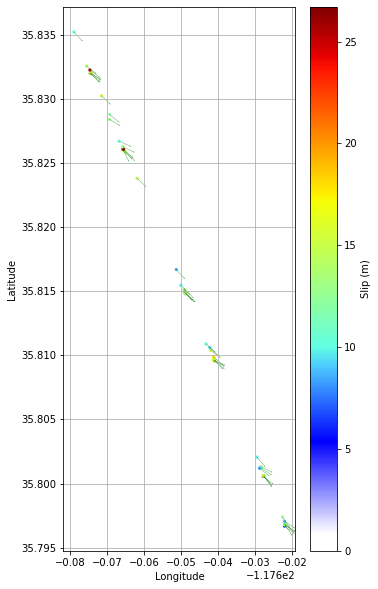

In [25]:
view.quick_model(rupt = rupt)

... working on subfault 0 of 54
... working on subfault 10 of 54
... working on subfault 20 of 54
... working on subfault 30 of 54
... working on subfault 40 of 54
... working on subfault 50 of 54


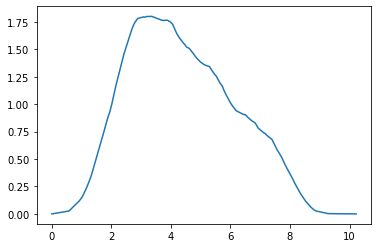

In [52]:
stf = view.source_time_function_FQ(rupt = rupt, epicenter = 0)
plt.plot(stf[0], stf[1]);